# Cyclones
In this project, I am going to cluster cyclone (usually called typhoon in Taiwan) trajectories which have struck Taiwan.<br>
In the following text, I will use the words "cyclone" and "trajectory" interchangeably. Both means "cyclone trajectory".

## Prerequisites
Before running this notebook, one needs to run the following notebooks first.
- `data_cleaning/coastlines_near_taiwan.ipynb` prepares coastline data which are close to Taiwan. These coastlines will be used in map plotting.
- `data_cleaning/cyclones_near_taiwan.ipynb` prepares trajectory data which are close to Taiwan. These trajectories are what clustering aims for.

## The program starts here

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 40)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
mpl.rcdefaults()

from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score as s_score
import dtw
from itertools import repeat

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Here we define some utility functions. It is ok not to understand what they do, as they are not at the heart of data analysis.

In [2]:
def label_by_freq(labels):
    return np.argsort(np.argsort(-np.bincount(labels)))[labels]

def reset_labels(srs, s):
    srs[srs.str.startswith(s)] = s

def set_labels(srs, s, labels):
    reset_labels(srs, s)
    srs[srs.str.startswith(s)] += [label.zfill(2) for label in label_by_freq(labels).astype(str)]

def min_max_scale(arr):
    max_, min_ = arr.max(), arr.min()
    return (arr - min_) / (max_ - min_)

def plot_trjs(cyclone_idxs, colors=None, alpha=1.):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if colors is None:
        colors = repeat(None)
    elif colors.ndim == 1:
        unique = np.unique(colors)
        colors = pd.Series(
            np.arange(unique.shape[0]), index=unique
        ).loc[colors].to_numpy()
        cmap = mpl.cm.get_cmap('gist_rainbow', 100)
        unique_colors = cmap(np.linspace(0., (unique.shape[0] - 1) / unique.shape[0], unique.shape[0]))
        ax.legend(handles=[
            mpatches.Patch(color=color, label=label)
        for color, label in zip(unique_colors, unique)])
        colors = unique_colors[colors]
        
    for cyclone_idx, color in zip(cyclone_idxs, colors):
        trj = trjs[sids[cyclone_idx]]
        
        for i in range(trj.shape[0] - 2, -1, -1):
            dx, dy = trj[-1, 0] - trj[i, 0], trj[-1, 1] - trj[i, 1]
            norm = np.sqrt(dx ** 2. + dy ** 2.)
            if norm > 0.:
                break
        dx /= norm
        dy /= norm
        
        line2d = ax.plot(
            trj[:, 0], trj[:, 1], '-', linewidth=.5,
            alpha=alpha, c=color
        )[0]
        ax.arrow(
            trj[-1, 0] - dx, trj[-1, 1] - dy, dx, dy, 
            head_width=10, head_length=20, shape='full', 
            color=line2d.get_c(), alpha=alpha
        )
        
    for cl in coastlines:
        ax.plot(cl[0], cl[1], c='black', linewidth=1)
    ax.set_xlim(-border, border)
    ax.set_ylim(-border, border)
    ax.grid();
    ax.set_aspect('equal');
    
    return fig, ax

I am going to use package python-dtw to perform dynamic time warpping (dtw) on the trajectories. However, the behavior of this package is not explained very clearly in its documentation, so I perform some experiments to understand how it works. The dtw distance of a zero-valued constant univariate time series of length `m` and a `y`-valued constant univariate time series of length `n` are computed.<br>
The experiment shows that:
- `distance` = `y` * (`m` + `n` - 1)
- `normalizedDistance` = `distance` / (`m` + `n`), implying that `normalizedDistance` = `y` * (1 - 1 / (`m` + `n`))
- `normalizedDistance` -> `y` as `m` and `n` become large.
- `normalizedDistance` is a distance, not a squared distance.

I conclude that it is appropriate to use `normalizedDistance` as a distance measure between two trajectories. Typically, the length of a trajectory is about 30, which guarantees that `m` and `n` are large enough.

In [3]:
y = 7.
for m in range(1, 10):
    for n in range(1, 10):
        alignment = dtw.dtw(np.full((m,), 0.), np.full((n,), y))
        print(
            alignment.M, alignment.N, 
            alignment.distance, y * (alignment.M + alignment.N - 1),
            alignment.normalizedDistance, alignment.distance / (alignment.M + alignment.N)
        )

1 1 7.0 7.0 3.5 3.5
2 1 14.0 14.0 4.666666666666667 4.666666666666667
3 1 21.0 21.0 5.25 5.25
4 1 28.0 28.0 5.6 5.6
5 1 35.0 35.0 5.833333333333333 5.833333333333333
6 1 42.0 42.0 6.0 6.0
7 1 49.0 49.0 6.125 6.125
8 1 56.0 56.0 6.222222222222222 6.222222222222222
9 1 63.0 63.0 6.3 6.3
1 2 14.0 14.0 4.666666666666667 4.666666666666667
2 2 21.0 21.0 5.25 5.25
3 2 28.0 28.0 5.6 5.6
4 2 35.0 35.0 5.833333333333333 5.833333333333333
5 2 42.0 42.0 6.0 6.0
6 2 49.0 49.0 6.125 6.125
7 2 56.0 56.0 6.222222222222222 6.222222222222222
8 2 63.0 63.0 6.3 6.3
9 2 70.0 70.0 6.363636363636363 6.363636363636363
1 3 21.0 21.0 5.25 5.25
2 3 28.0 28.0 5.6 5.6
3 3 35.0 35.0 5.833333333333333 5.833333333333333
4 3 42.0 42.0 6.0 6.0
5 3 49.0 49.0 6.125 6.125
6 3 56.0 56.0 6.222222222222222 6.222222222222222
7 3 63.0 63.0 6.3 6.3
8 3 70.0 70.0 6.363636363636363 6.363636363636363
9 3 77.0 77.0 6.416666666666667 6.416666666666667
1 4 28.0 28.0 5.6 5.6
2 4 35.0 35.0 5.833333333333333 5.833333333333333
3 4 42.0 4

Now I load the cleansed data. <br>
If, in the coastlines part, it prints `Cannot load file containing pickled data when allow_pickle=False`, don't worry. The code still works. I will try fix this problem in the future.

In [4]:
coastlines = []
with open('../repository/coastlines_near_taiwan.npy', 'rb') as f:
    try:
        while True:
            coastlines.append(np.load(f))
    except Exception as e:
        print(e)

Cannot load file containing pickled data when allow_pickle=False


In [5]:
df = pd.read_pickle('../repository/cyclones_taiwan.pkl')
sids = df['SID'].unique()
print(len(sids))
groupby = df.groupby('SID')
trjs = {sid: group[['x', 'y']].to_numpy() for sid, group in groupby}

1021


Now the coastlines are stored in `coastlines`. These coastlines are not very detailed. Many islands are omitted. However, they are enough in purpose of positioning.      <br>
The trajectories are stored in the dictionary `trjs` with sids as keys and trajectories as values. An sid is a unique id for a cyclone. A trajectory is a n by 2 numpy array, where n is the length of the trajectory and 2 is by the fact that it has coordinates x and y. In other words, a trajectory is a bivariate time series of length n.<br>
The above output shows that we have 1021 trajectories in total. See `data_cleaning/cyclones_near_taiwan.ipynb` for how we filter and preprocess trajectories.<br>
All sids are stored in the pandas series `sids`.

The pandas series `srs_cyclone` stores labels for the trajectories in the data analysis procedure. `srs` stands for "series".

In [6]:
srs_cyclone = pd.Series('', index=pd.RangeIndex(stop=len(sids)), dtype=str, name='label')

Let's give these trajectories a plot. We see that most cyclones come from the South-East.

In [7]:
border = 1250.

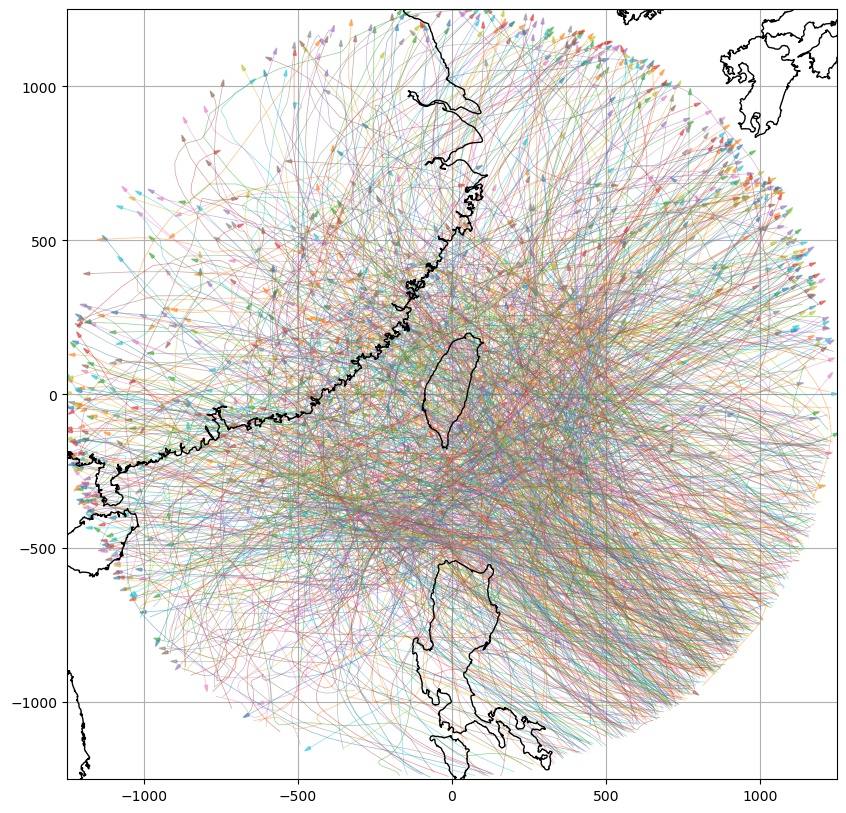

In [8]:
s = ''
fig, ax = plot_trjs(srs_cyclone.index[srs_cyclone.str.startswith(s)], alpha=.5)
ax.set_title(s, size=30);

Here I use dtw to compute the all pair distance matrix for all trajectories. Latter I will use thie distance matrix in clustering. This takes several minutes. I save the result as a file, so I don't need to compute it again if this notebook is restarted.<br>
In fact, it only needs to compute a half of this matrix bacause it should be symmetric. This saves time. I will fix this problem in the future.

In [9]:
dist_mat = np.array([[
    dtw.dtw(trjs[sid_0], trjs[sid_1]).normalizedDistance 
for sid_1 in sids] for sid_0 in sids])
with open('../repository/cyclones_dist_mat.npy', 'wb') as f:
    np.save(f, dist_mat)

In [10]:
with open('../repository/cyclones_dist_mat.npy', 'rb') as f:
    dist_mat = np.load(f)
print(dist_mat.nbytes, dist_mat.shape, np.allclose(dist_mat, dist_mat.T))

8339528 (1021, 1021) True


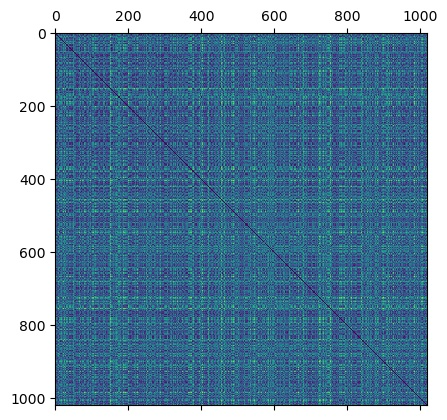

In [11]:
plt.matshow(dist_mat);

The following plot shows that those trajectories are of distance around 450 from each other.

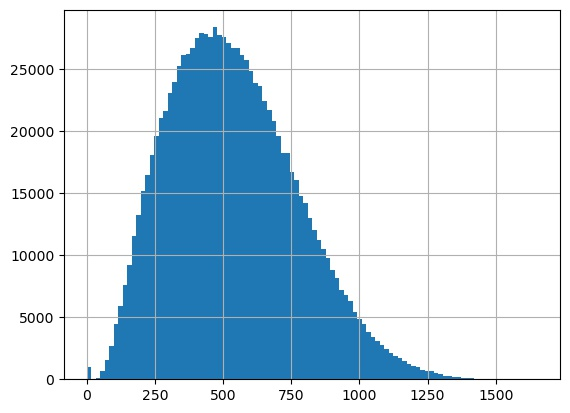

In [12]:
plt.hist(dist_mat.flatten(), bins=100);
plt.grid();

Now I find some outlier trajectories. <br>
The densities at each trajectories are computed using kernel density estimation with Gaussian kernel. See https://scikit-learn.org/stable/modules/density.html#kernel-density for details.

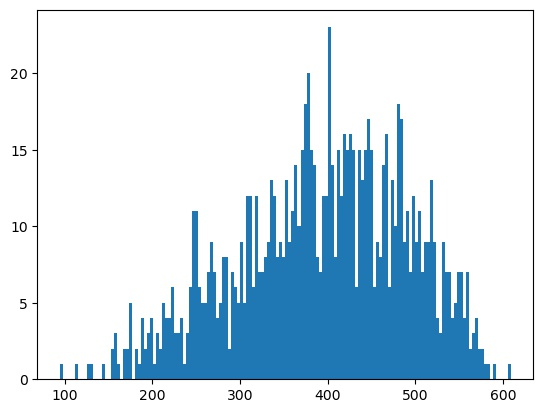

In [13]:
alpha = 250000.
sim_mat = np.exp(-(dist_mat ** 2 / alpha))
densities = sim_mat.sum(axis=1)
plt.hist(densities, bins=150);

The next plot shows that the majority of cyclones strikes Taiwan from the South-East.

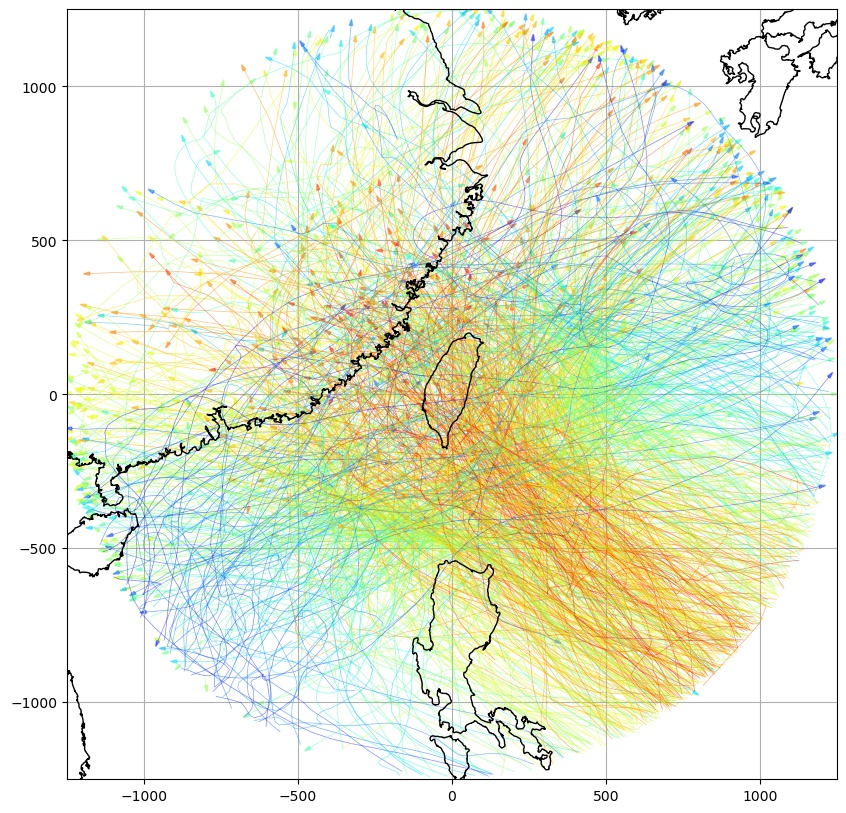

In [14]:
fig, ax = plot_trjs(
    srs_cyclone.index, 
    colors=mpl.cm.get_cmap('jet', 100)(min_max_scale(densities)),
    alpha=.5
)
ax.set_title(s, size=30);

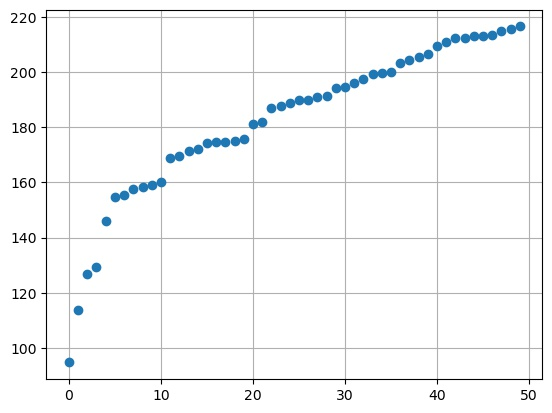

In [15]:
plt.plot(densities[np.argsort(densities)[:50]], 'o');
plt.grid();

According to the above plot, it seems reasonable to mark the 11 trajectories with least densities as outliers, denoted `x`. The trajectories which are not outliers are called regular trajectories, denoted `r`.

In [16]:
srs_cyclone.iloc[np.argsort(densities)[:11]] = 'x'
srs_cyclone[srs_cyclone != 'x'] = 'r'
srs_cyclone.value_counts()

r    1010
x      11
Name: label, dtype: int64

The outlier trajectories are plotted in the following figure. Some of the outliers are short, and some others strike China from the South and turns sharply to the East. These are not the usual case. We have seen that most cyclones come from the South-East.

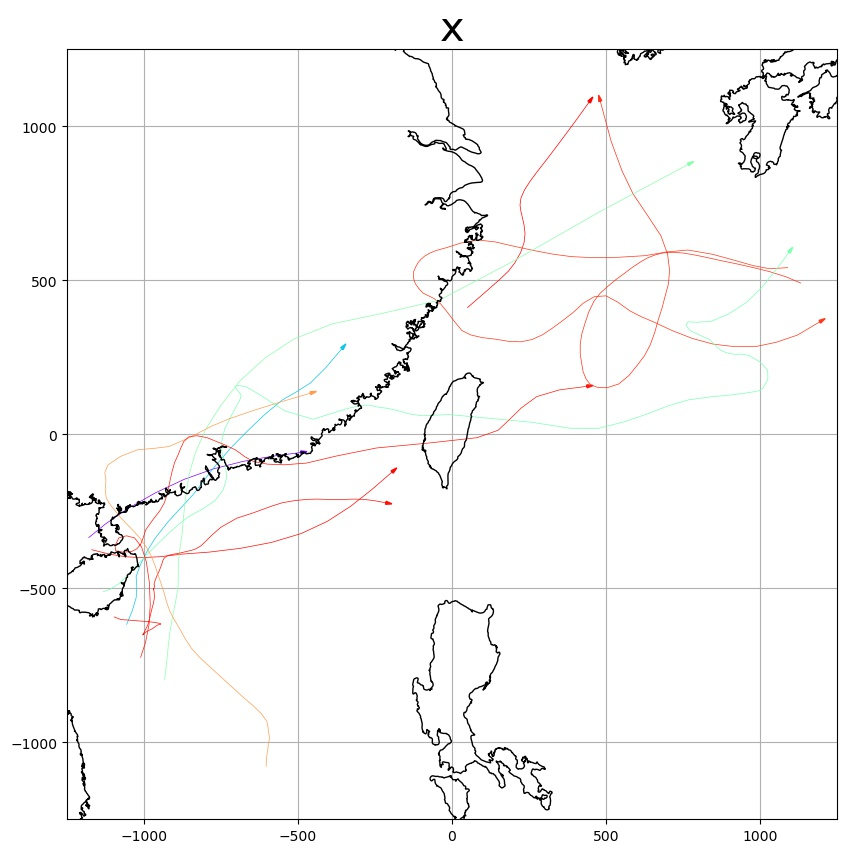

In [17]:
s = 'x'
fig, ax = plot_trjs(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    colors=mpl.cm.get_cmap('rainbow', 100)(min_max_scale(densities[srs_cyclone.str.startswith(s)]))
)
ax.set_title(s, size=30);

Here I perform clustering on the regular trajectories, or more specifically, the regular part of the distance matrix. After trying many clustering algorithms, I found spectral clustering yield good result. Spectral clustering will compute the required similarity matrix from our distance matrix based on a nearest neighbors principle.<br>
I choose the number of clusters as 4, which has high Silhouette Coefficient compared to other numbers. 2 also scores high, but is too coarse for analysis. Note that applying Silhouette Coefficient to non-spherical clusters is problematic. I will fix this problem in the future.

In [18]:
s = 'r'
for_clust = dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)]
for i in range(2, 10):
    labels = SpectralClustering(
        n_clusters=i, affinity='precomputed_nearest_neighbors', 
        random_state=0, n_neighbors=50
    ).fit(for_clust).labels_
    print(i, s_score(for_clust, labels, metric='precomputed'))

2 0.3107540848833248
3 0.27041345957172896
4 0.2815840780673313
5 0.2533416810924811
6 0.25739599400017027
7 0.23297768189019982
8 0.2254449423038395
9 0.2371793300508354


In [19]:
s = 'r'
for_clust = dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)]
labels = SpectralClustering(
    n_clusters=4, affinity='precomputed_nearest_neighbors', 
    random_state=0, n_neighbors=50
).fit(for_clust).labels_
set_labels(srs_cyclone, s, labels)

In [20]:
srs_cyclone.value_counts().sort_index()

r00    303
r01    270
r02    256
r03    181
x       11
Name: label, dtype: int64

Now the regular trajectories is divided into 4 clusters of size 303, 270, 256, and 181, along with 11 outliers. I then plot these trajectory clusters, as well as the distance matrix with rows and columns reordered by clusters. <br> 
From the plots we see that the clustering does a good job. Similar trajectories are clustered together. 
- Cluster `r00` mainly consists of cyclones coming from the South-East, dodging Taiwan, and going to the North-East.
- Cluster `r01` mainly consists of cyclones coming from the South-East, passing Bashi Channel between Taiwan and Philippines, and going to the West.
- Cluster `r02` mainly consists of cyclones coming from the South-East, passing Taiwan, and going to the North-West.
- Cluster `r03` mainly consists of cyclones coming from the South and going to the North-East.

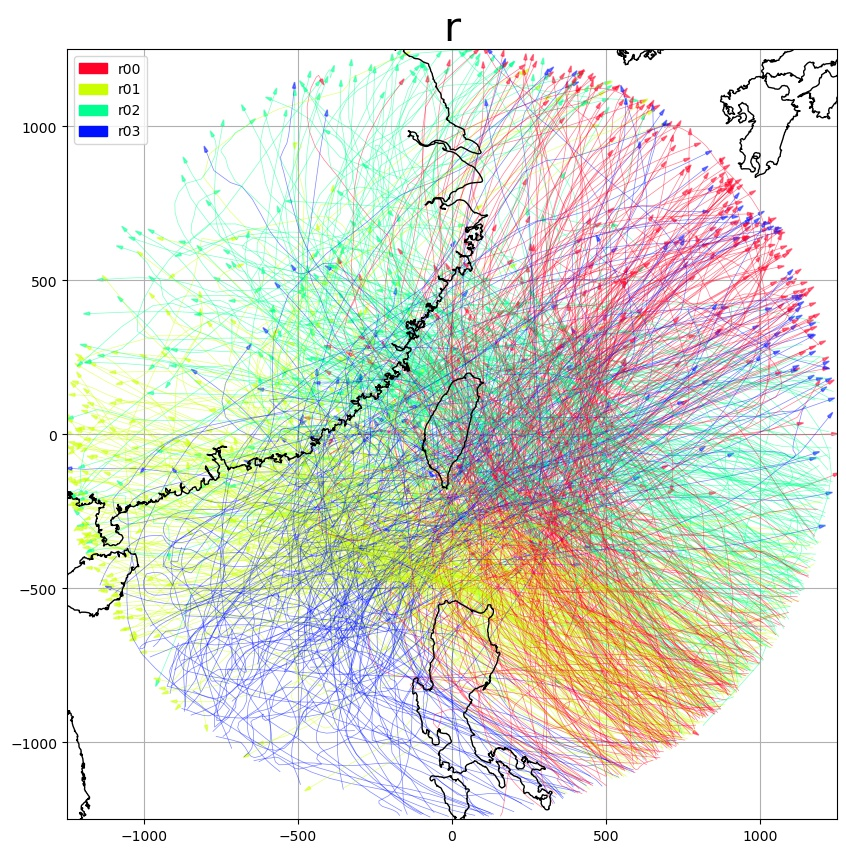

In [21]:
s = 'r'
fig, ax = plot_trjs(
    srs_cyclone.index[srs_cyclone.str.startswith(s)],
    colors=srs_cyclone[srs_cyclone.str.startswith(s)], alpha=.5
)
ax.set_title(s, size=30);

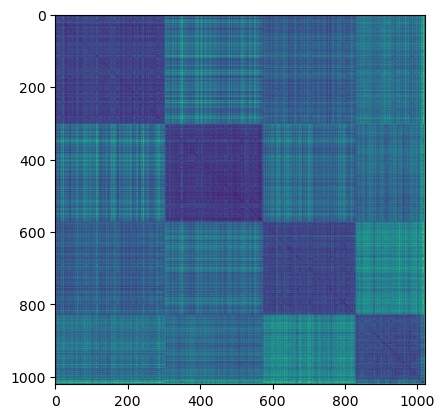

In [22]:
plt.imshow(dist_mat[np.ix_(
    srs_cyclone.sort_values().index, srs_cyclone.sort_values().index
)]);

I have shown how the clusters differ from each other. In the following I am going to talk about the variation within a single cluster. <br>
For each cluster, I am going to plot its trajectories, with colors determined by a special method. t-SNE is used to transform the trajectories in a single cluster into points in a 2 dimensional space. The color for a trajectory is determined according to the position of its cooresponding point. I hope similar trajectories get similar colors. Turns out that this works well, as we will see.

For cluster `r00`, we see that brown and green cyclones dodge Taiwan well, though of different angles, while orange ones bump into the Eastern Taiwan.

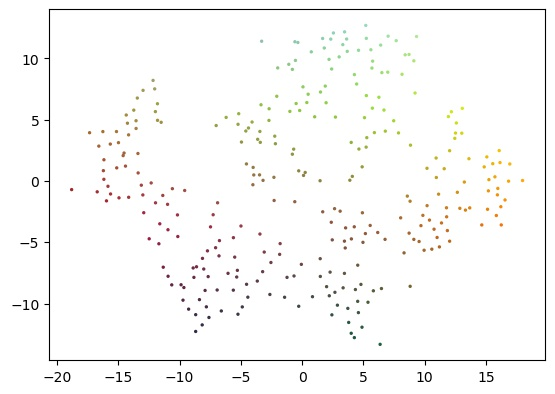

In [23]:
s = 'r00'
emb = TSNE(
    n_components=2, metric='precomputed', square_distances=True,
    init='random', perplexity=30., random_state=0, learning_rate='auto'
).fit_transform(dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)])
fig, ax = plt.subplots()
colors = (
    mpl.cm.get_cmap('viridis', 100)(min_max_scale(emb[:, 0])) + \
    mpl.cm.get_cmap('hot', 100)(min_max_scale(emb[:, 1]))
) / 2.
ax.scatter(emb[:, 0], emb[:, 1], s=2, c=colors);
ax.set_aspect('equal');

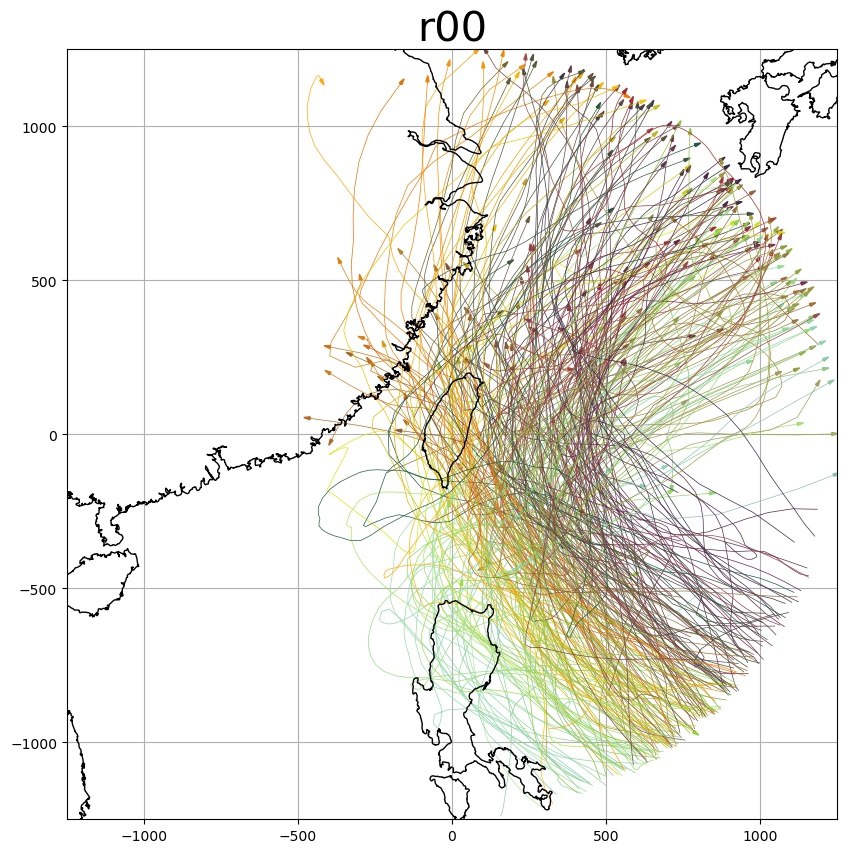

In [24]:
fig, ax = plot_trjs(srs_cyclone.index[srs_cyclone.str.startswith(s)], colors=colors)
ax.set_title(s, size=30);

For cluster `r01`, we see that brown cyclones take more horizontal routes, while green ones are more inclined.

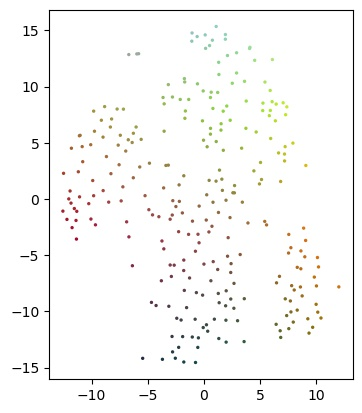

In [25]:
s = 'r01'
emb = TSNE(
    n_components=2, metric='precomputed', square_distances=True,
    init='random', perplexity=30., random_state=0, learning_rate='auto'
).fit_transform(dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)])
fig, ax = plt.subplots()
colors = (
    mpl.cm.get_cmap('viridis', 100)(min_max_scale(emb[:, 0])) + \
    mpl.cm.get_cmap('hot', 100)(min_max_scale(emb[:, 1]))
) / 2.
ax.scatter(emb[:, 0], emb[:, 1], s=2, c=colors);
ax.set_aspect('equal');

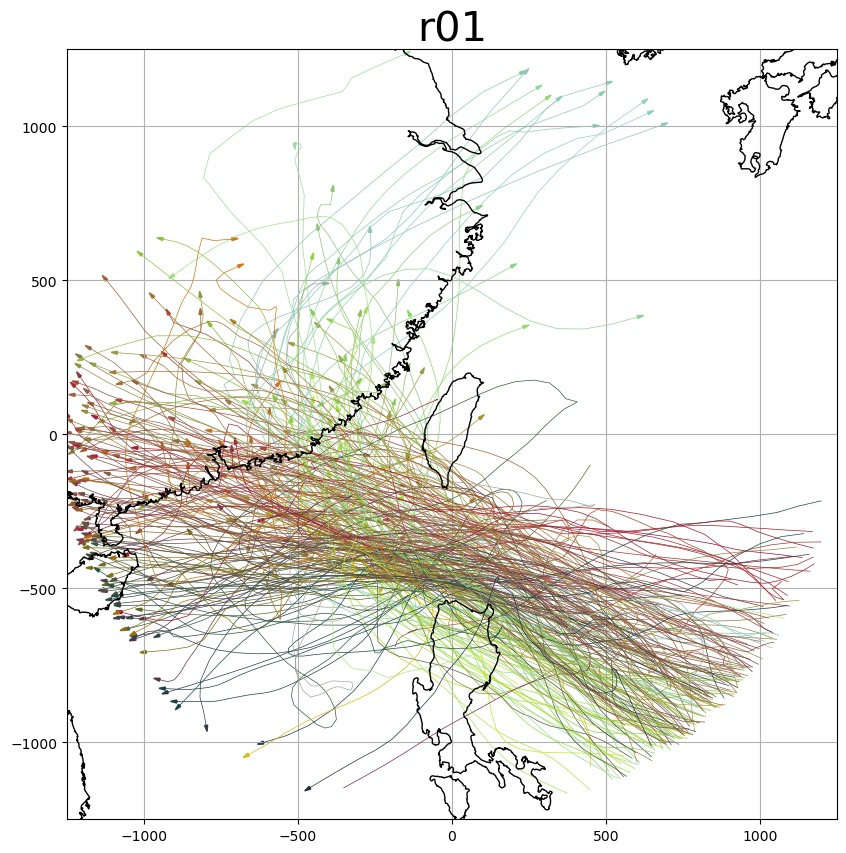

In [26]:
fig, ax = plot_trjs(srs_cyclone.index[srs_cyclone.str.startswith(s)], colors=colors)
ax.set_title(s, size=30);

For cluster `r02`, we see that red cyclones take more horizontal routes, while the others are more inclined.

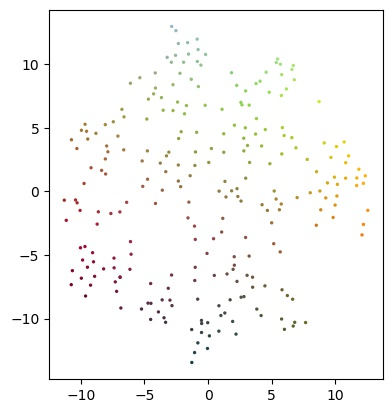

In [27]:
s = 'r02'
emb = TSNE(
    n_components=2, metric='precomputed', square_distances=True,
    init='random', perplexity=30., random_state=0, learning_rate='auto'
).fit_transform(dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)])
fig, ax = plt.subplots()
colors = (
    mpl.cm.get_cmap('viridis', 100)(min_max_scale(emb[:, 0])) + \
    mpl.cm.get_cmap('hot', 100)(min_max_scale(emb[:, 1]))
) / 2.
ax.scatter(emb[:, 0], emb[:, 1], s=2, c=colors);
ax.set_aspect('equal');

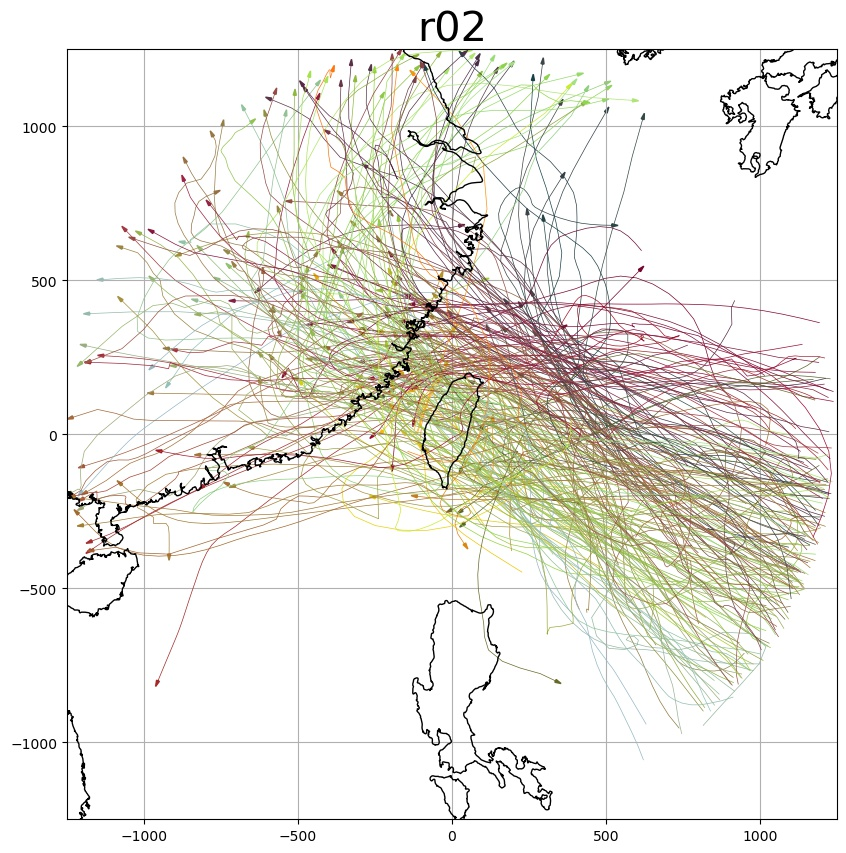

In [28]:
fig, ax = plot_trjs(srs_cyclone.index[srs_cyclone.str.startswith(s)], colors=colors)
ax.set_title(s, size=30);

For cluster `r03`, we see that orange cyclones dodge Taiwan, green ones bump into Taiwan, and brown ones bump into China and have more complex trajectories. <br>

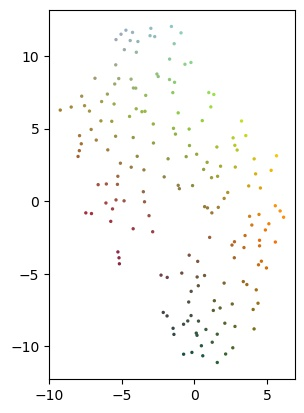

In [29]:
s = 'r03'
emb = TSNE(
    n_components=2, metric='precomputed', square_distances=True,
    init='random', perplexity=30., random_state=0, learning_rate='auto'
).fit_transform(dist_mat[np.ix_(
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
    srs_cyclone.index[srs_cyclone.str.startswith(s)], 
)])
fig, ax = plt.subplots()
colors = (
    mpl.cm.get_cmap('viridis', 100)(min_max_scale(emb[:, 0])) + \
    mpl.cm.get_cmap('hot', 100)(min_max_scale(emb[:, 1]))
) / 2.
ax.scatter(emb[:, 0], emb[:, 1], s=2, c=colors);
ax.set_aspect('equal');

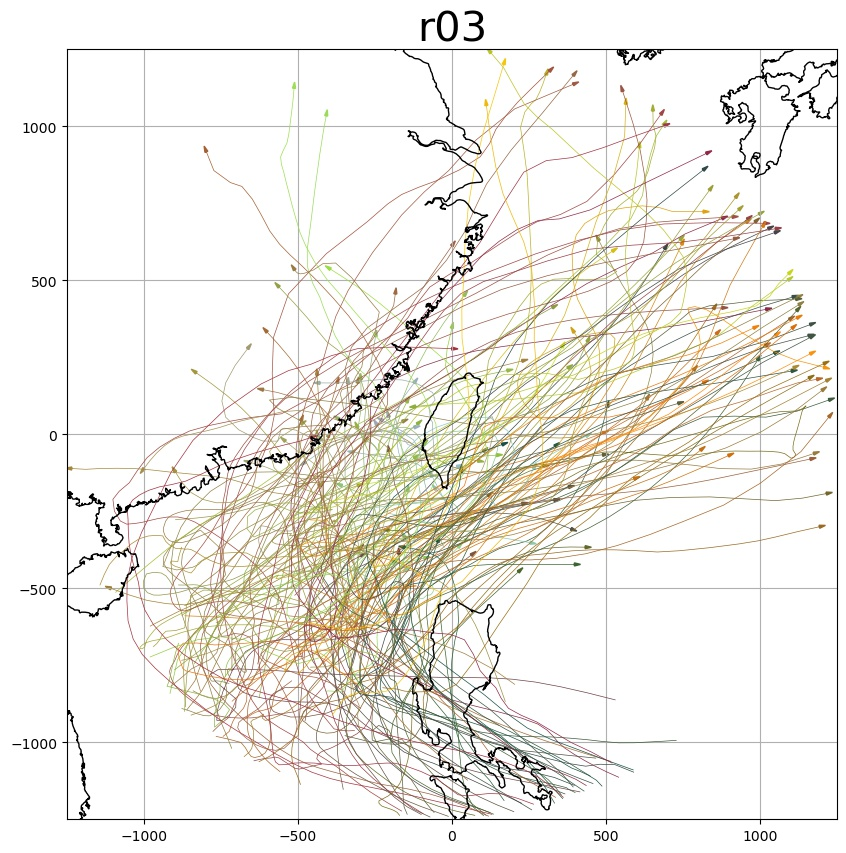

In [30]:
fig, ax = plot_trjs(srs_cyclone.index[srs_cyclone.str.startswith(s)], colors=colors)
ax.set_title(s, size=30);

The program ends here.

## To do list
- `Cannot load file containing pickled data when allow_pickle=False`
- Compute only half of dist_mat
- Better way to select n_clusters
- A cyclone is not merely a trajectory. Other attributes, such as intensity and rainfall, or environmental factors can be considered to yield better analysis

## Environment

In [31]:
import sys, os, subprocess
print('I run this jupyter notebook in a conda environment called ', end='')
print(sys.executable.split('/')[-3])
filename = 'cyclones.ipynb'
subprocess.check_output([
    'pipreqsnb', '--use-local', '--print', 
    os.path.join(os.getcwd(), filename)
]).decode().strip().split('\n')[:-1]

I run this jupyter notebook in a conda environment called ts


INFO: Successfully output requirements


['dtw==1.4.0',
 'dtw_python==1.1.10',
 'matplotlib==3.4.3',
 'numpy==1.21.2',
 'pandas==1.3.4',
 'scikit_learn==1.0.1']